In [47]:
import gym
import numpy as np
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

def moving_average(x, N):
    return np.convolve(x, np.ones(N, ), mode='valid') / N

Episode 99 finished after 204 timesteps
Episode 199 finished after 140 timesteps
Episode 299 finished after 145 timesteps
Episode 399 finished after 125 timesteps
Episode 499 finished after 159 timesteps
Episode 599 finished after 108 timesteps
Episode 699 finished after 135 timesteps
Episode 799 finished after 122 timesteps
Episode 899 finished after 134 timesteps
Episode 999 finished after 123 timesteps
Episode 1099 finished after 121 timesteps
Episode 1199 finished after 102 timesteps
Episode 1299 finished after 89 timesteps
Episode 1399 finished after 119 timesteps
Episode 1499 finished after 210 timesteps


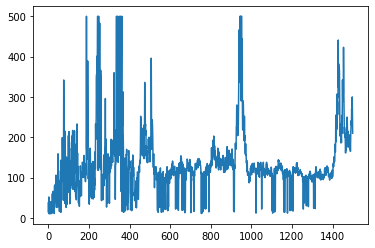

In [53]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []
        self.dones = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

policy = Policy()
optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
#     print('rewards_arr', rewards_arr)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def train_on_rollout(gamma=0.99):
    returns = discount_rewards(policy.rewards, gamma)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    
def train_on_batch(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.mean().backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    del policy.dones[:]

def learn_n_step_A2C(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 30

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                train_on_batch(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards
N_EPS = 1500
rewards_A2C = learn_n_step_A2C(N_EPS, 500)
plt.plot(rewards_A2C)

PPO:

<img src="./asd.png" style="width: 70%"> </img>

Episode 99 finished after 26 timesteps
Episode 199 finished after 343 timesteps
Episode 299 finished after 268 timesteps
Episode 399 finished after 232 timesteps
Episode 499 finished after 148 timesteps
Episode 599 finished after 172 timesteps
Episode 699 finished after 464 timesteps
Episode 799 finished after 242 timesteps
Episode 899 finished after 500 timesteps
Episode 999 finished after 500 timesteps
Episode 1099 finished after 500 timesteps
Episode 1199 finished after 500 timesteps
Episode 1299 finished after 500 timesteps
Episode 1399 finished after 500 timesteps
Episode 1499 finished after 500 timesteps


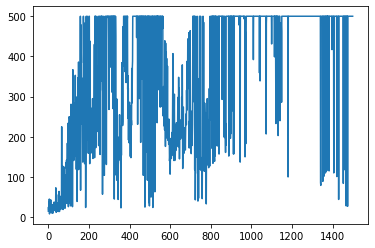

In [45]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.states = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values.squeeze()

policy = Policy()
policy_old = Policy()
policy_old.load_state_dict(policy.state_dict())

optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy_old(state)
    m = Categorical(probs)
    action = m.sample()
    policy.actions.append(action.item())
    policy.logprobs.append(m.log_prob(action).item())
    policy.states.append(state)
#     policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def evaluate_policy(states, old_actions):
    probs, values = policy.forward

def batch_update_agent(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    
    states = torch.stack(policy.states).float()
#     print(states.shape)
    old_actions = policy.actions
#     print(old_actions)
    old_logprobs = torch.tensor(policy.logprobs).float()
#     print(old_logprobs.shape)
    
    # PPO OLD VALUES
    for i in range(2):
        # Calculate needed values    
        p, v = policy.forward(states)
        m = Categorical(p)
        c = m.log_prob(torch.tensor(old_actions))
        entr = m.entropy()

        # value fn loss
        loss_vf = F.mse_loss(v, returns)

        # surrogate loss
        advantage = returns - v.detach()
        r_ts = torch.exp(c - old_logprobs)
        loss_surr = - (torch.min(r_ts * advantage, torch.clamp(r_ts, 1-0.2, 1+0.2) * advantage)).mean()
        
        # maximize entropy bonus
        loss_entropy = - 0.0001 * entr.mean()

        # the total_loss
        loss_total = loss_vf + loss_surr + loss_entropy
        
        # step
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
#         raise Exception('1111')

    policy_old.load_state_dict(policy.state_dict())    
    
    del policy.actions[:]
    del policy.states[:]
    del policy.logprobs[:]
    del policy.rewards[:]
    del policy.dones[:]

def learn_PPO_single_threaded(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 300

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                batch_update_agent(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards

N_EPS =500
rewards_PPO = learn_PPO_single_threaded(N_EPS*3, 500)
plt.plot(rewards_PPO)

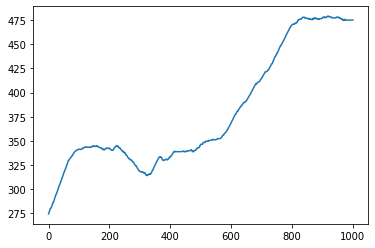

In [51]:
plt.plot(moving_average(rewards_PPO, 500))

### TODO

try to train the model on r + V(x') - V(x) advantage